In [1]:
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt
scf.set_figure_pubready()

In [2]:
adata=sc.read("data/adata_assigned.h5ad")

In [3]:
adata_Hub=adata[adata.obs.Hub_leiden=="True"]

In [4]:
import seaborn as sns

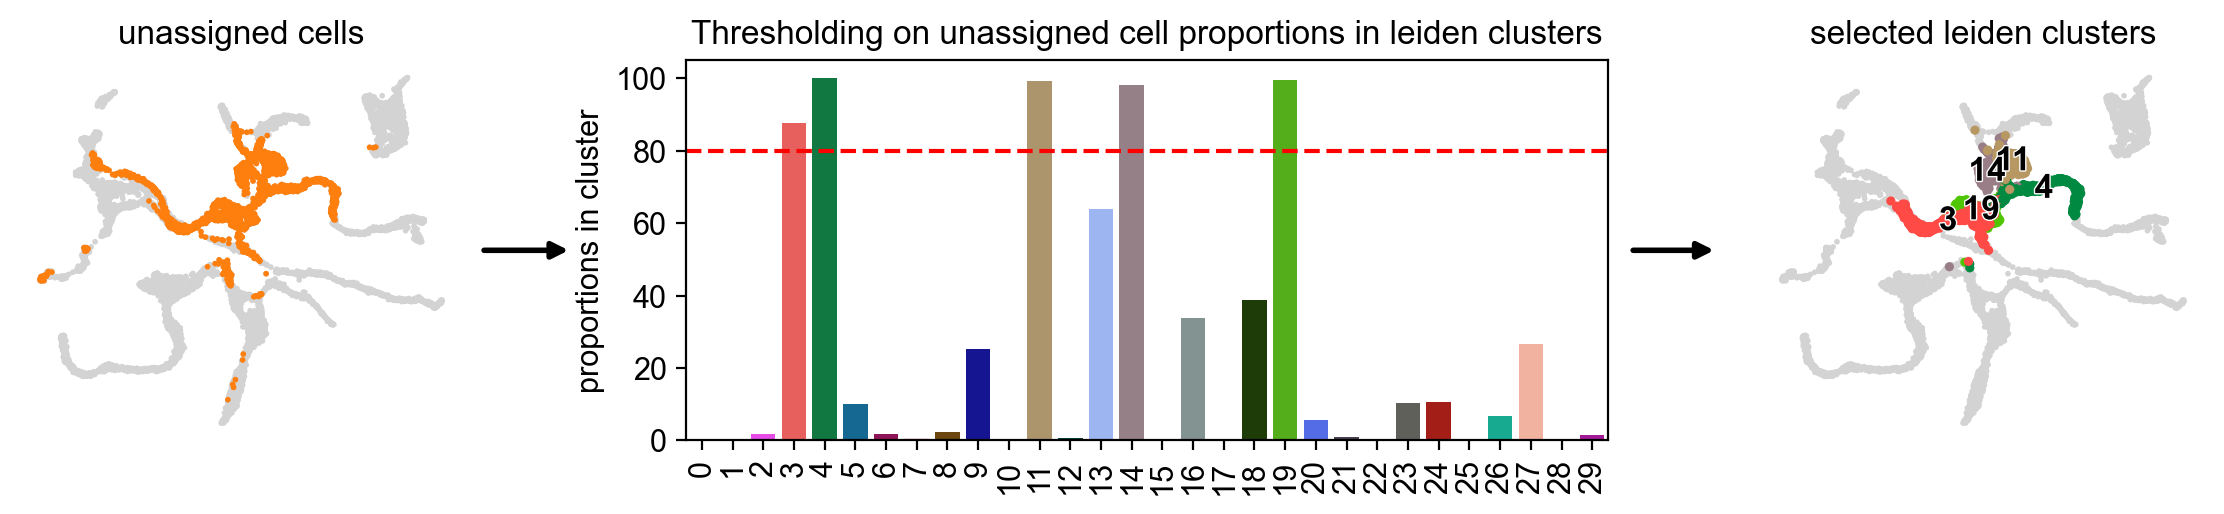

In [40]:
import scvelo as scv
import pandas as pd
props=adata.obs.groupby(["leiden","Hub"]).size().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
props=pd.Series([props[l]["True"] for l in adata.obs.leiden.cat.categories],index=adata.obs.leiden.cat.categories)

scv.set_figure_params(figsize=(3,3))

fig, axs= plt.subplots(1,5,figsize=(14,2.5),gridspec_kw=dict(width_ratios=[1.2,0.2,2.5,0.01,1.2]))


scv.pl.umap(adata,color="Hub",groups=["True"],title="unassigned cells",legend_loc="none",ax=axs[0],show=False)

axs[1].axis("off")
axs[1].annotate("", xy=(.5, .5), xytext=(-.8,.5),
                arrowprops=dict(arrowstyle="-|>",facecolor="k",
                                connectionstyle = 'arc3',linewidth=2))

sns.barplot(x=adata.obs.leiden.cat.categories,y=props,palette=adata.uns["leiden_colors"].tolist(),ax=axs[2])
axs[2].axhline(80,linestyle="--",color="r")
axs[2].set_ylabel("proportions in cluster")
axs[2].set_title("Thresholding on unassigned cell proportions in leiden clusters")
plt.setp(axs[2].get_xticklabels(), rotation=90, va="center",ha="right", rotation_mode="anchor");

axs[3].axis("off")
axs[3].annotate("", xy=(10, .5), xytext=(-15,.5), annotation_clip=False,
                arrowprops=dict(arrowstyle="-|>",facecolor="k",
                                connectionstyle = 'arc3',linewidth=2))

scv.pl.umap(adata,color="lightgrey",title="",legend_loc="none",ax=axs[4],show=False)
scv.pl.umap(adata_Hub,color="leiden",ax=axs[4],title="selected leiden clusters",show=False)
plt.savefig("figures/fig2-A.pdf",bbox_inches="tight")

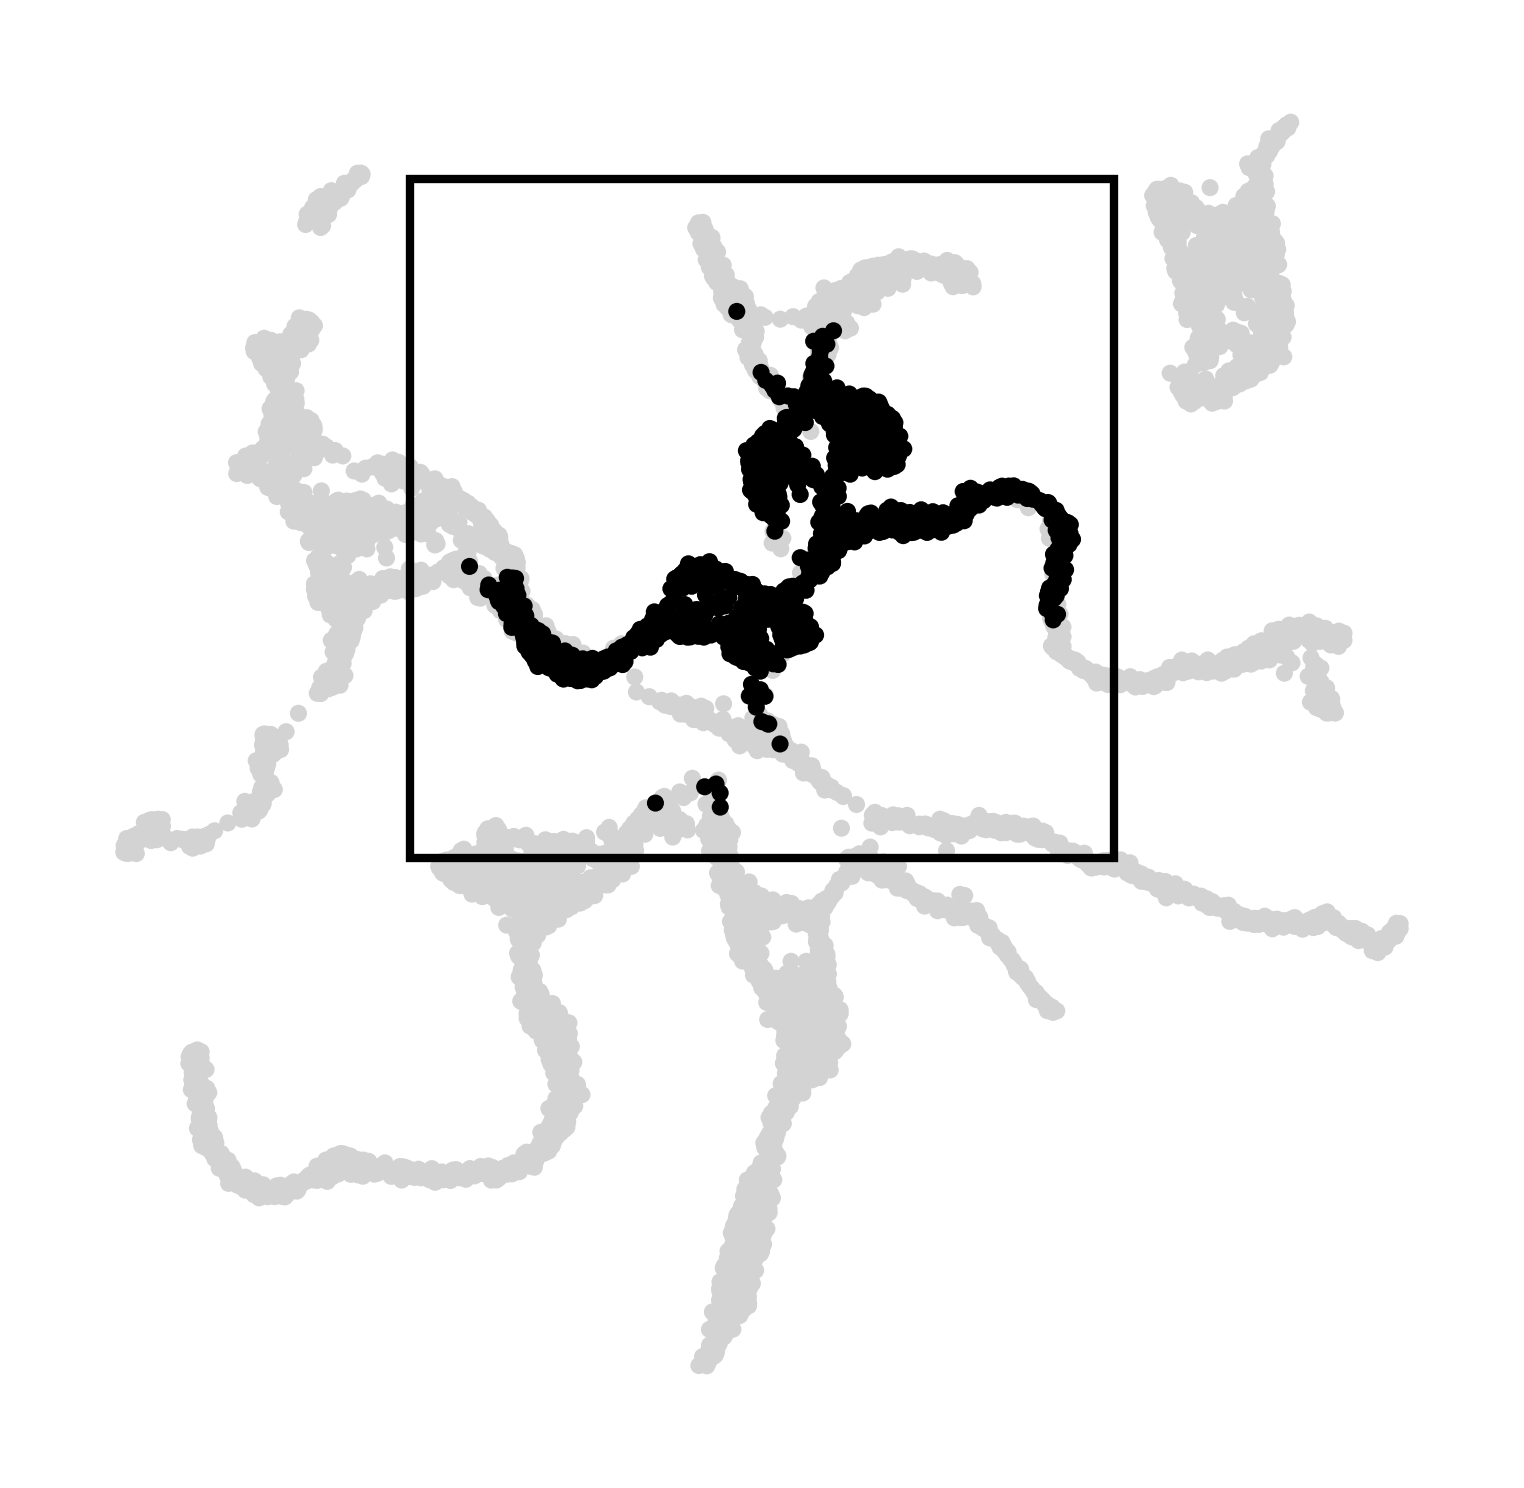

In [41]:
import scvelo as scv
import matplotlib.patches as patches
scv.set_figure_params(figsize=(3,3),dpi=300)
ax=scv.pl.umap(adata,color="Hub_leiden",groups=["True"],title="",palette=["k"],legend_loc="none",show=False)
rect = patches.Rectangle((-3,1),15,15,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(rect)
plt.savefig("figures/fig2-B.pdf",dpi=300,bbox_inches="tight")

In [42]:
dev_counts=adata.obs.loc[adata.obs.Hub_leiden=="True","devtime"].value_counts()

dev_counts=dev_counts[dev_counts>0]

dct_dev=dict(zip(adata.obs.devtime.cat.categories,adata.uns["devtime_colors"]))

adata.obs.location=adata.obs.location.cat.rename_categories({"Sympathoadrenal system":"SA system"})
dct_loc=dict(zip(adata.obs.location.cat.categories,adata.uns["location_colors"]))
loc_counts=adata.obs.loc[adata.obs.Hub_leiden=="True","location"].value_counts()

loc_counts=loc_counts[loc_counts>0]

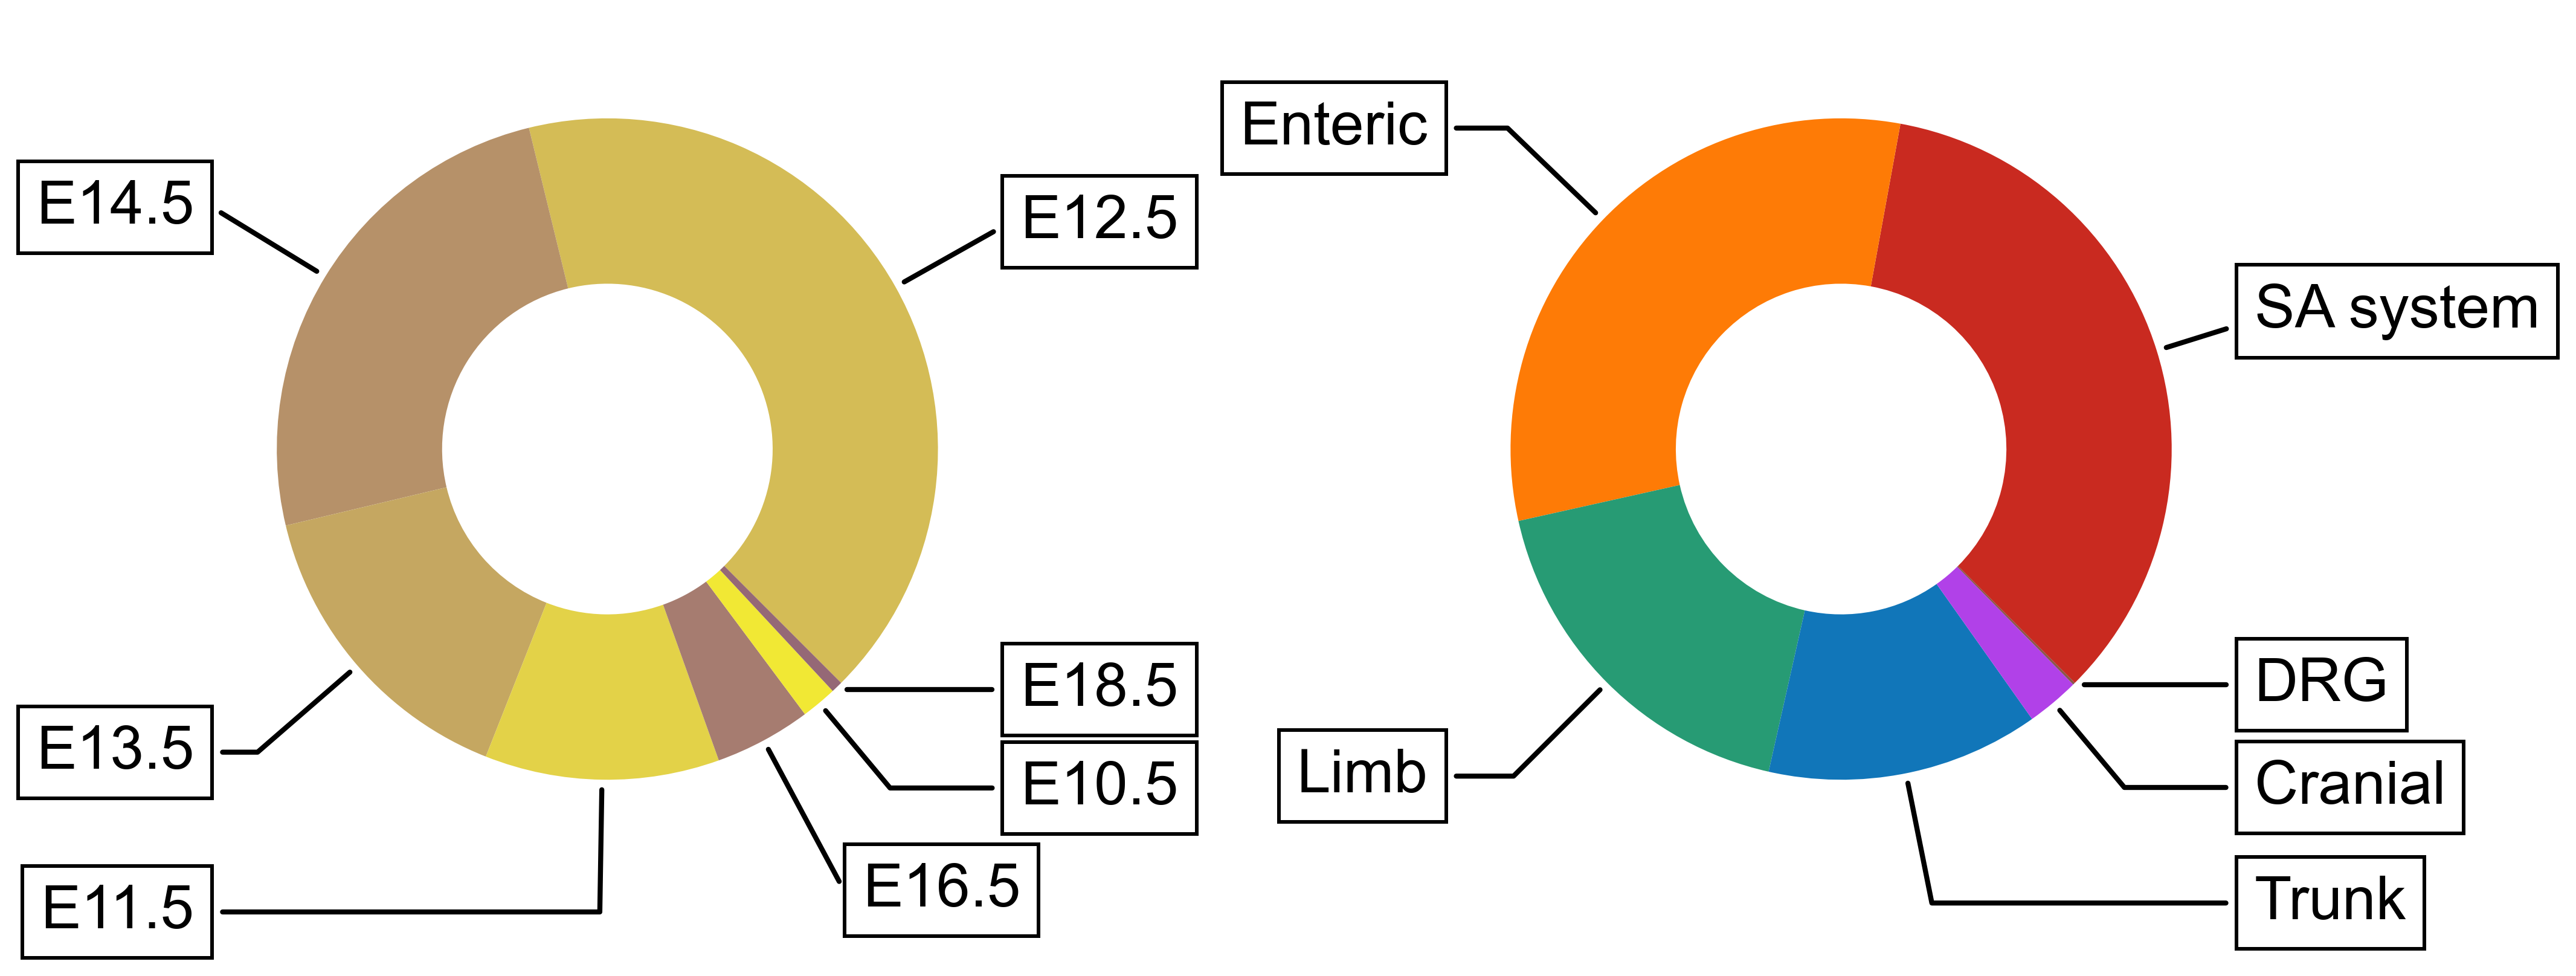

In [43]:
import numpy as np
fig, axs = plt.subplots(1,2,figsize=(8, 3), subplot_kw=dict(aspect="equal"),gridspec_kw=dict(width_ratios=[1,1.2]))

wedges, texts = axs[0].pie(dev_counts.values, wedgeprops=dict(width=0.5), startangle=-45,colors=[dct_dev[d] for d in dev_counts.index])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    xyt=[1.25*np.sign(x), 1.4*y]
    if dev_counts.index[i]=="E16.5":
        horizontalalignment="right"
        xyt[1]=xyt[1]-.1
    if dev_counts.index[i]=="E18.5":
        xyt[1]=xyt[1]+.28
    if dev_counts.index[i]=="E10.5":
        xyt[1]=xyt[1]+.05
    if dev_counts.index[i]=="P0":
        break
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[0].annotate(dev_counts.index[i], xy=(x, y), xytext=xyt,
                horizontalalignment=horizontalalignment, **kw)

wedges, texts = axs[1].pie(loc_counts.values, wedgeprops=dict(width=0.5), startangle=-45,colors=[dct_loc[d] for d in loc_counts.index])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    xyt=[1.25*np.sign(x), 1.4*y]
    if loc_counts.index[i]=="DRG":
        xyt[1]=xyt[1]+.28
        
    if loc_counts.index[i]=="Cranial":
        xyt[1]=xyt[1]+.05
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[1].annotate(loc_counts.index[i], xy=(x, y), xytext=xyt,
                horizontalalignment=horizontalalignment, **kw)
    
plt.savefig("figures/fig2-C.pdf",bbox_inches="tight")

In [52]:
import seaborn as sns
def gen_barplot(adata,loc,ax,proplab=True,xrem=False):
    adata=adata[adata.obs.location==loc]
    adata=adata[~adata.obs.devtime.isin(['P0','P2', 'P6', 'P10', 'Adult'])]
    df=adata.obs[adata.obs.Hub_leiden=="True"].devtime.value_counts()/adata.obs.devtime.value_counts()
    df=df.to_frame()

    df["dev"]=df.index

        
    #fig,ax = plt.subplots(figsize=(len(adata.obs.devtime.cat.categories)/3,1.5))
    sns.barplot(x="dev",y="devtime", data=df,palette=adata.uns["devtime_colors"],ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45,ha="right", va="center", rotation_mode="anchor");
    ax.set_xlabel("")
    if proplab:
        ax.set_ylabel("proportion")
    else:
        ax.set_ylabel("")
    if xrem:
        ax.set_xticks([])
    ax.set_title(loc,fontsize=10)
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])


kw = dict(arrowprops=dict(arrowstyle="<|-",facecolor="k",
                         connectionstyle = "angle,angleA=0,angleB=90"),
          bbox=bbox_props, zorder=0, va="center",
          xycoords="axes fraction",
          annotation_clip=False)

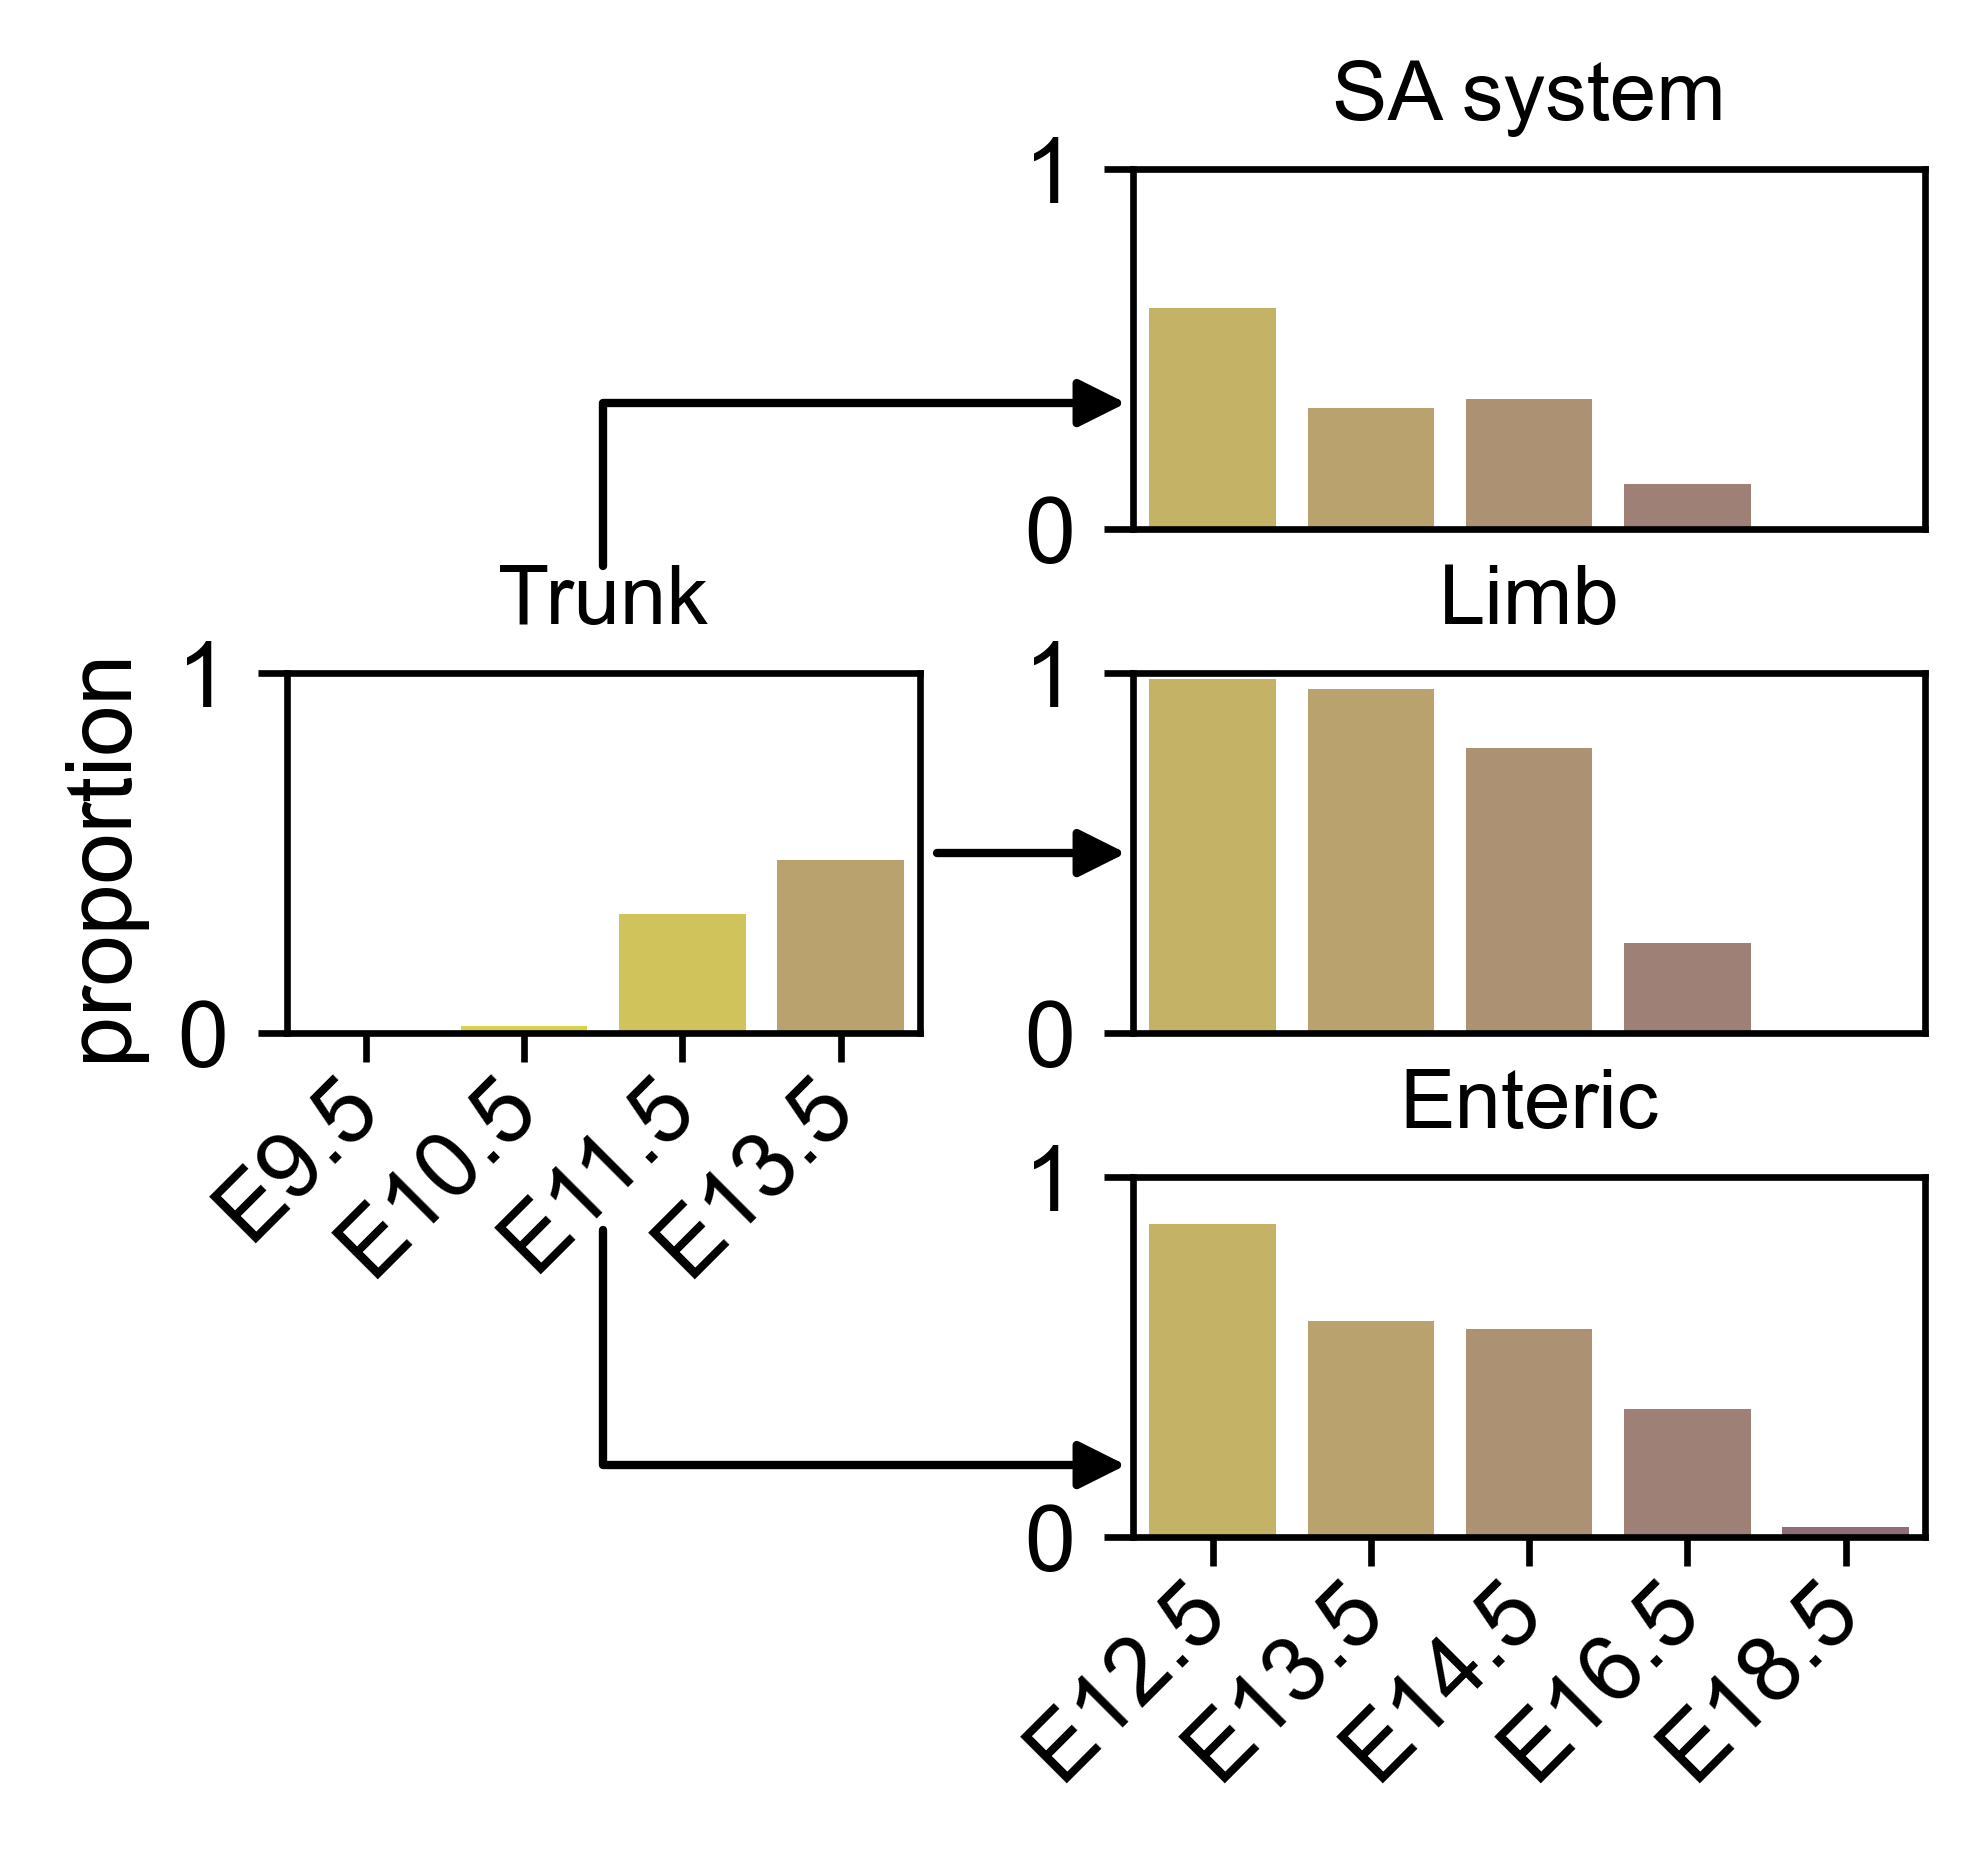

In [45]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(3.5,3))
gs0 = gridspec.GridSpec(1, 2, figure=fig,width_ratios=[1,1.25],wspace=.3)
gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0],hspace=.4)
axt= fig.add_subplot(gs00[1])   
gen_barplot(adata,"Trunk",axt)

axt.annotate("", xy=(.5, 1.25), xytext=(1.4,1.75), **kw)
axt.annotate("", xy=(1, .5), xytext=(1.4,.5), **kw)
axt.annotate("", xy=(.5, -.5), xytext=(1.4,-1.2), **kw)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1],hspace=.4)
axt= fig.add_subplot(gs00[0])   
gen_barplot(adata,"SA system",axt,xrem=True,proplab=False)
axt= fig.add_subplot(gs00[1])   
gen_barplot(adata,"Limb",axt,xrem=True,proplab=False)
axt= fig.add_subplot(gs00[2])   
gen_barplot(adata,"Enteric",axt,proplab=False)
plt.savefig("figures/fig2-C.pdf",bbox_inches="tight")

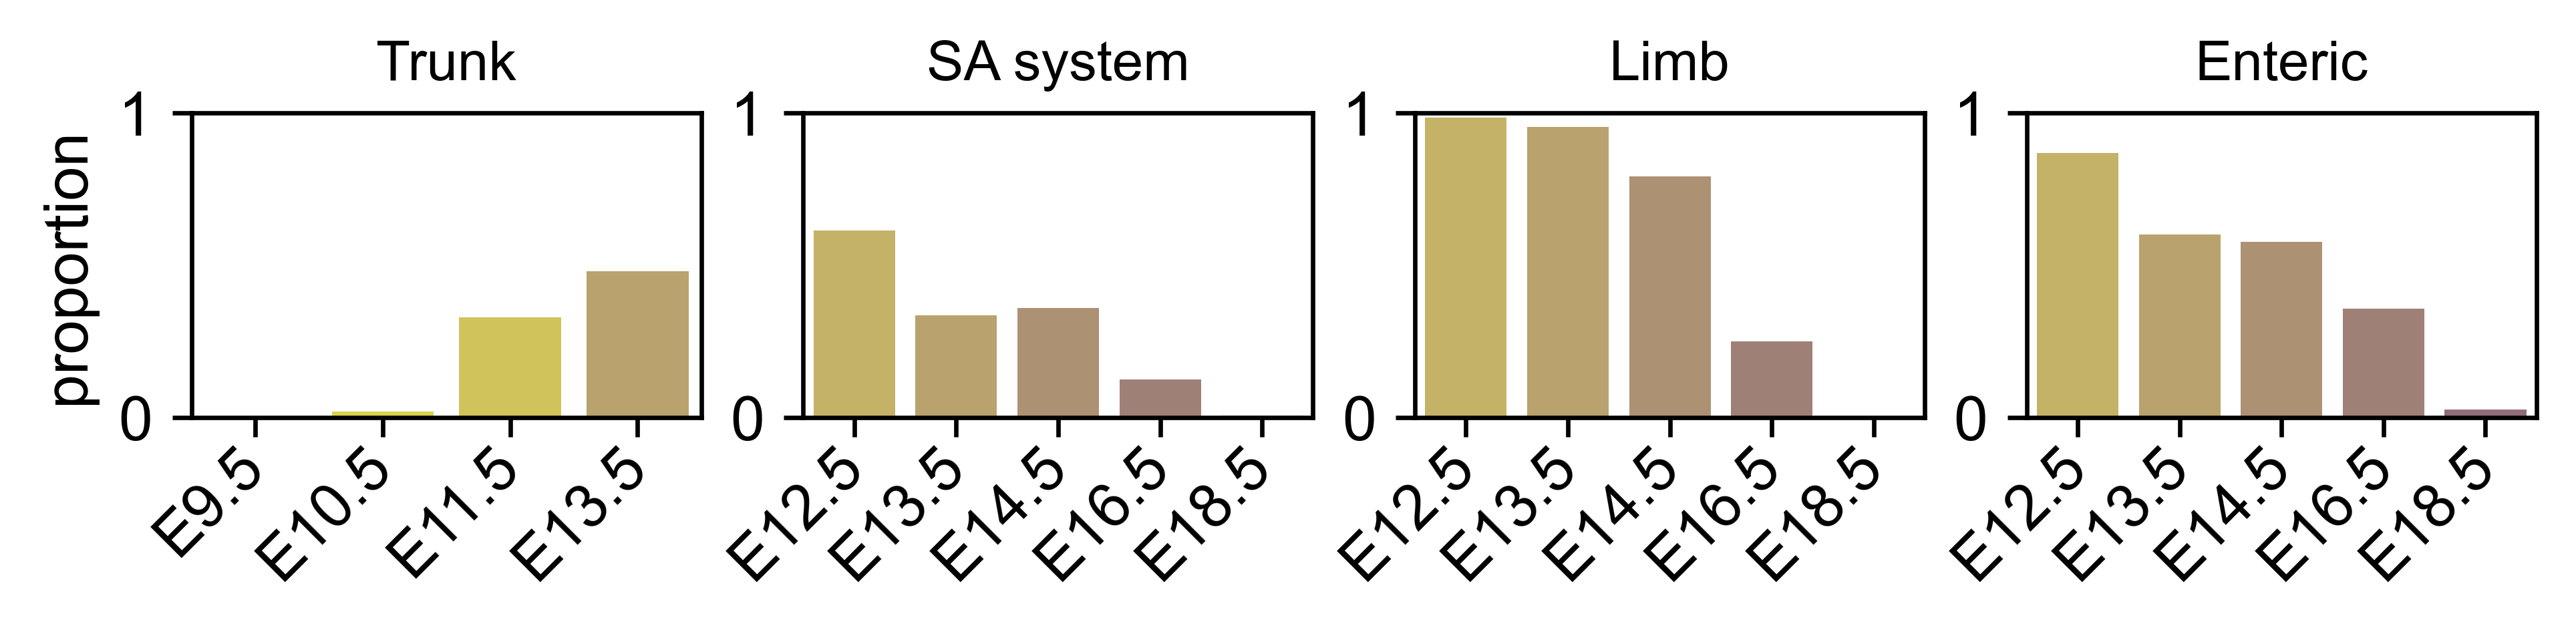

In [57]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7.5,1))
gs0 = gridspec.GridSpec(1, 4, figure=fig,wspace=.2)
axt= fig.add_subplot(gs0[0])   
gen_barplot(adata,"Trunk",axt)
axt= fig.add_subplot(gs0[1])   
gen_barplot(adata,"SA system",axt,proplab=False)
axt= fig.add_subplot(gs0[2])   
gen_barplot(adata,"Limb",axt,proplab=False)
axt= fig.add_subplot(gs0[3])   
gen_barplot(adata,"Enteric",axt,proplab=False)
plt.savefig("figures/fig2-C.pdf",bbox_inches="tight")

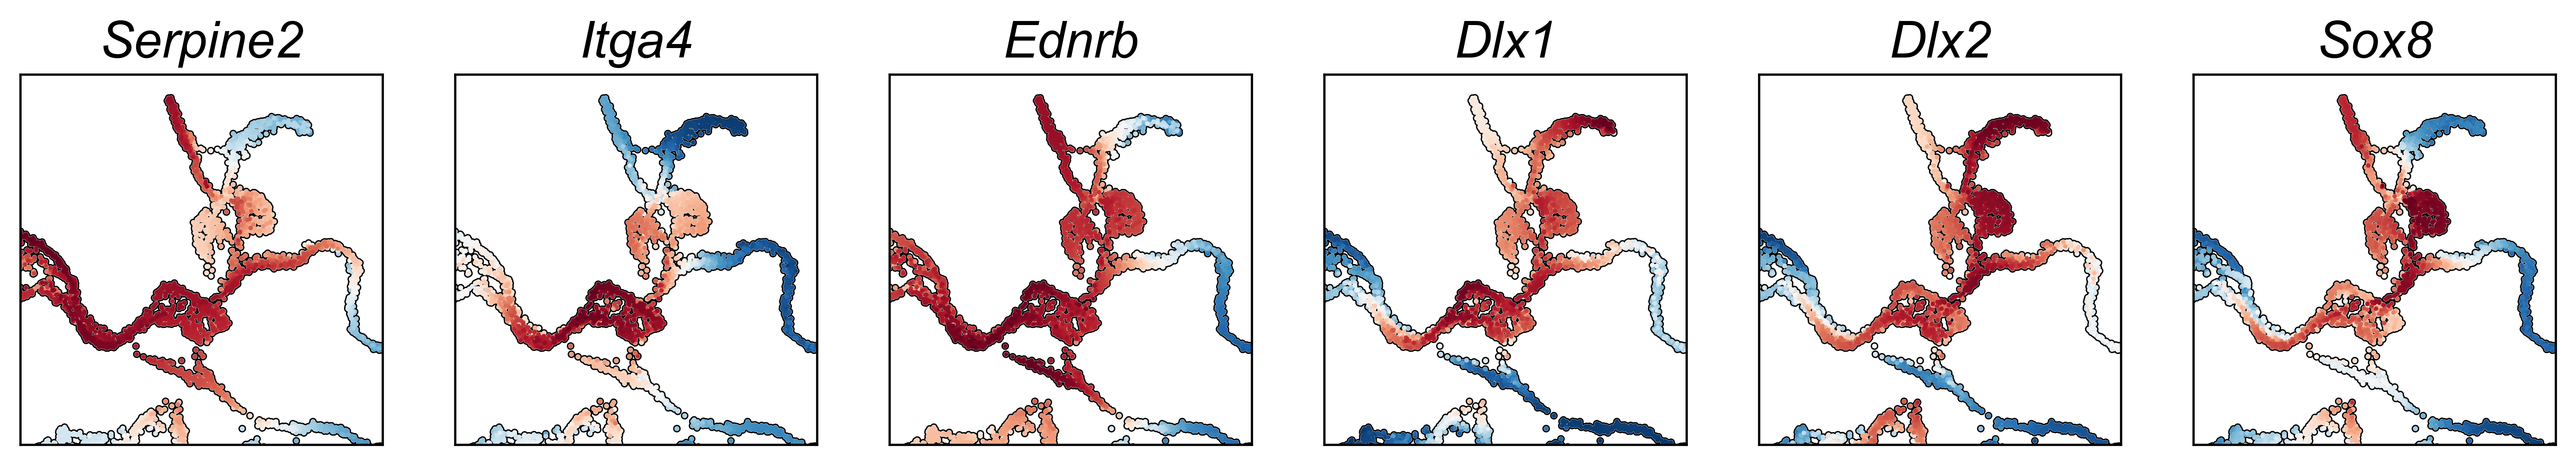

In [58]:
fig,axs = plt.subplots(1,6,figsize=(16,2.4))
axs=axs.ravel()
for i,g in enumerate(["Serpine2","Itga4","Ednrb","Dlx1","Dlx2","Sox8"]):
    scv.pl.umap(adata,color=g,legend_loc=1,title="",show=False,ax=axs[i],add_outline=True,s=10,layer="palantir_imp",colorbar=False,frameon=True)
    axs[i].set_xlim((-3,-3+15))
    axs[i].set_ylim((1,1+15))
    axs[i].set_title(g,style="italic",fontsize=18)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
#plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/fig2-D.pdf",bbox_inches="tight")

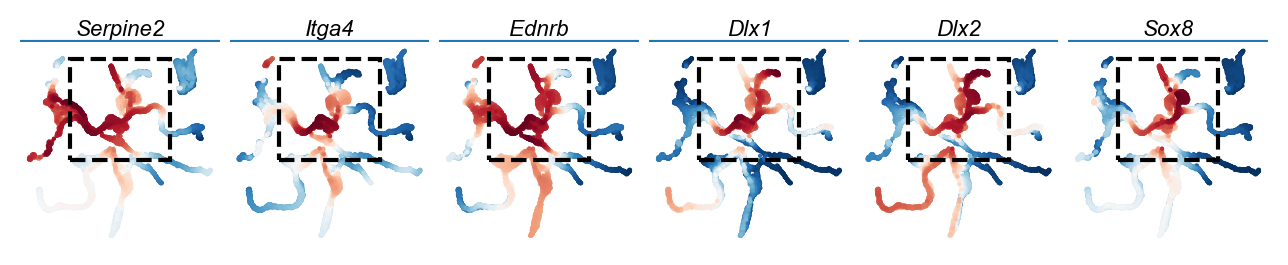

In [95]:
markers=dict(zip(["Serpine2","Itga4","Ednrb","Dlx1","Dlx2","Sox8"],["Serpine2","Itga4","Ednrb","Dlx1","Dlx2","Sox8"]))
celltypes=list(markers.keys())

scv.set_figure_params(figsize=(2.6,2.6),dpi_save=300)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8,6))
def set_title(ax,title):
    ax.text(0.5, 0.1, title, va="bottom", style="italic",ha="center",fontsize=8)
    ax.axis("off")
    ax.axhline(0)
    
def plot_marker(ax,g):
    scv.pl.umap(adata,color=g,colorbar=False,s=10,layer="palantir_imp",title="",show=False,ax=ax)
    rect = patches.Rectangle((-3,1),15,15,linewidth=1.5,edgecolor='k',facecolor='none',linestyle="--")
    ax.add_patch(rect)
    
def plot_multi(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)
    ncol=len(markers[celltype])
    gs0000 = gridspec.GridSpecFromSubplotSpec(1, ncol,subplot_spec=gs000[1])
    axt=[]
    for c in range(gs0000.ncols):
        axt.append(fig.add_subplot(gs0000[c]))
        plot_marker(axt[c],markers[celltype][c])
        
def plot_single(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)    
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)    
    axt = fig.add_subplot(gs000[1])
    plot_marker(axt,markers[celltype])
        
gs0 = gridspec.GridSpec(4, 1, figure=fig,hspace=0.025)
ix=0
## first row

lens=[[1,1,1,1,1,1]]

for i,rlen in enumerate(lens):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, len(rlen), width_ratios=rlen,subplot_spec=gs0[i],wspace=0.05)
    for j,l in enumerate(rlen):
        if l >1:
            plot_multi(celltypes[ix],gs00[j])
            ix=ix+1
        else:
            plot_single(celltypes[ix],gs00[j])
            ix=ix+1



plt.savefig("figures/fig2-D.pdf",bbox_inches="tight")

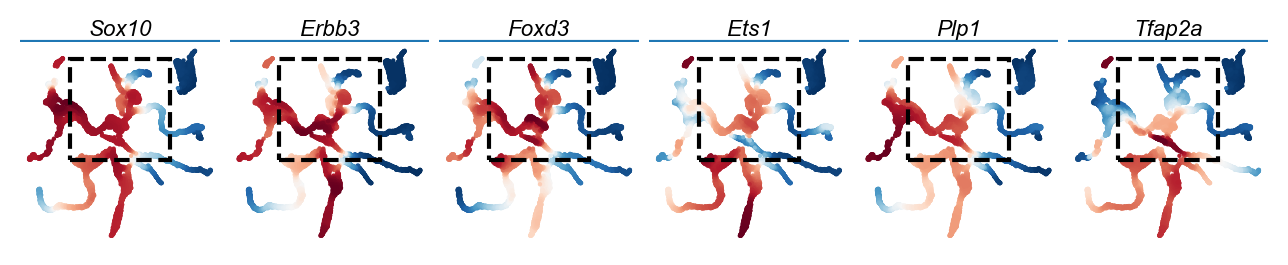

In [89]:
mar=["Sox10","Erbb3","Foxd3","Ets1","Plp1","Tfap2a"]
markers=dict(zip(mar,mar))
celltypes=list(markers.keys())

scv.set_figure_params(figsize=(2.6,2.6),dpi_save=300)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8,6))
def set_title(ax,title):
    ax.text(0.5, 0.1, title, va="bottom", ha="center",style="italic",fontsize=8)
    ax.axis("off")
    ax.axhline(0)
    
def plot_marker(ax,g):
    scv.pl.umap(adata,color=g,colorbar=False,s=10,layer="palantir_imp",
                smooth=True,perc=[1,99],title="",show=False,ax=ax)
    rect = patches.Rectangle((-3,1),15,15,linewidth=1.5,edgecolor='k',facecolor='none',linestyle="--")
    ax.add_patch(rect)
    
def plot_multi(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)
    ncol=len(markers[celltype])
    gs0000 = gridspec.GridSpecFromSubplotSpec(1, ncol,subplot_spec=gs000[1])
    axt=[]
    for c in range(gs0000.ncols):
        axt.append(fig.add_subplot(gs0000[c]))
        plot_marker(axt[c],markers[celltype][c])
        
def plot_single(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)    
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)    
    axt = fig.add_subplot(gs000[1])
    plot_marker(axt,markers[celltype])
        
gs0 = gridspec.GridSpec(4, 1, figure=fig,hspace=0.025)
ix=0
## first row

lens=[[1,1,1,1,1,1]]

for i,rlen in enumerate(lens):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, len(rlen), width_ratios=rlen,subplot_spec=gs0[i],wspace=0.05)
    for j,l in enumerate(rlen):
        if l >1:
            plot_multi(celltypes[ix],gs00[j])
            ix=ix+1
        else:
            plot_single(celltypes[ix],gs00[j])
            ix=ix+1



plt.savefig("figures/fig2-E.pdf",bbox_inches="tight")

In [90]:
import subprocess
files=["figures/fig2-A.pdf","figures/fig2-B.pdf"]


def get_ratio(file):
    command=('identify %s'%file).split()
    arr=np.array(subprocess.check_output(command).decode("utf-8").split(" ")[2].split("x"),dtype=int)
    return arr[0]/arr[1]

ratios=np.array([get_ratio(file) for file in files])
sum_ratios=ratios.sum()
a,b=(ratios/sum_ratios)-0.01

In [91]:
a

0.7989813466942008

In [92]:
fname="fig2"

In [96]:
%%bash -s $fname $a $b
cat<<EOF >$1.tex
\documentclass[11pt]{article}
\usepackage[paperheight=211mm,paperwidth=180mm]{geometry}
 \geometry{
 left=5mm,
 right=5mm,
 top=5mm,
 bottom=5mm,
 }

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx} 
\begin{document}
\setmainfont{Arial}

\definecolor{Blue}{RGB}{50, 49, 145}

\noindent
\scriptsize

\begin{minipage}[!ht]{.77\textwidth}
\raggedright \textbf{A} \textcolor{Blue}{Strategy of identification of hub cells}
\includegraphics[width=1\textwidth]{figures/fig2-A.pdf}
\end{minipage}\hfill
\begin{minipage}[!ht]{.22\textwidth}
\raggedright \textbf{B} \textcolor{Blue}{Cells assigned to the hub}
\includegraphics[width=.8\textwidth]{figures/fig2-B.pdf}
\end{minipage}\hfill


\begin{minipage}[t]{0.62\textwidth}
\raggedright \textbf{C} \textcolor{Blue}{Spatio-temporal transient aspect of the hub\vspace{-5pt}}
\includegraphics[width=1\textwidth]{figures/fig2-C.pdf}
\end{minipage}\hfill

\begin{minipage}[t]{1\textwidth}
\raggedright \textbf{D} \textcolor{Blue}{Main hub markers}
\includegraphics[width=1\textwidth]{figures/fig2-D.pdf}

\raggedright \textbf{E} \textcolor{Blue}{Pan-NCC/hub markers}
\includegraphics[width=1\textwidth]{figures/fig2-E.pdf}
\end{minipage}\hfill

\hfill
\clearpage


EOF

echo "\end{document}" >> $1.tex

xelatex --shell-escape $1.tex
rm fig2.tex
convert -flatten -density 300 $1.pdf $1.jpg
identify $1.pdf

This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)
 \write18 enabled.
entering extended mode
(./fig2.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption.sty
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption3.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/xetex.def))
(/usr/share/texlive/texmf-dist

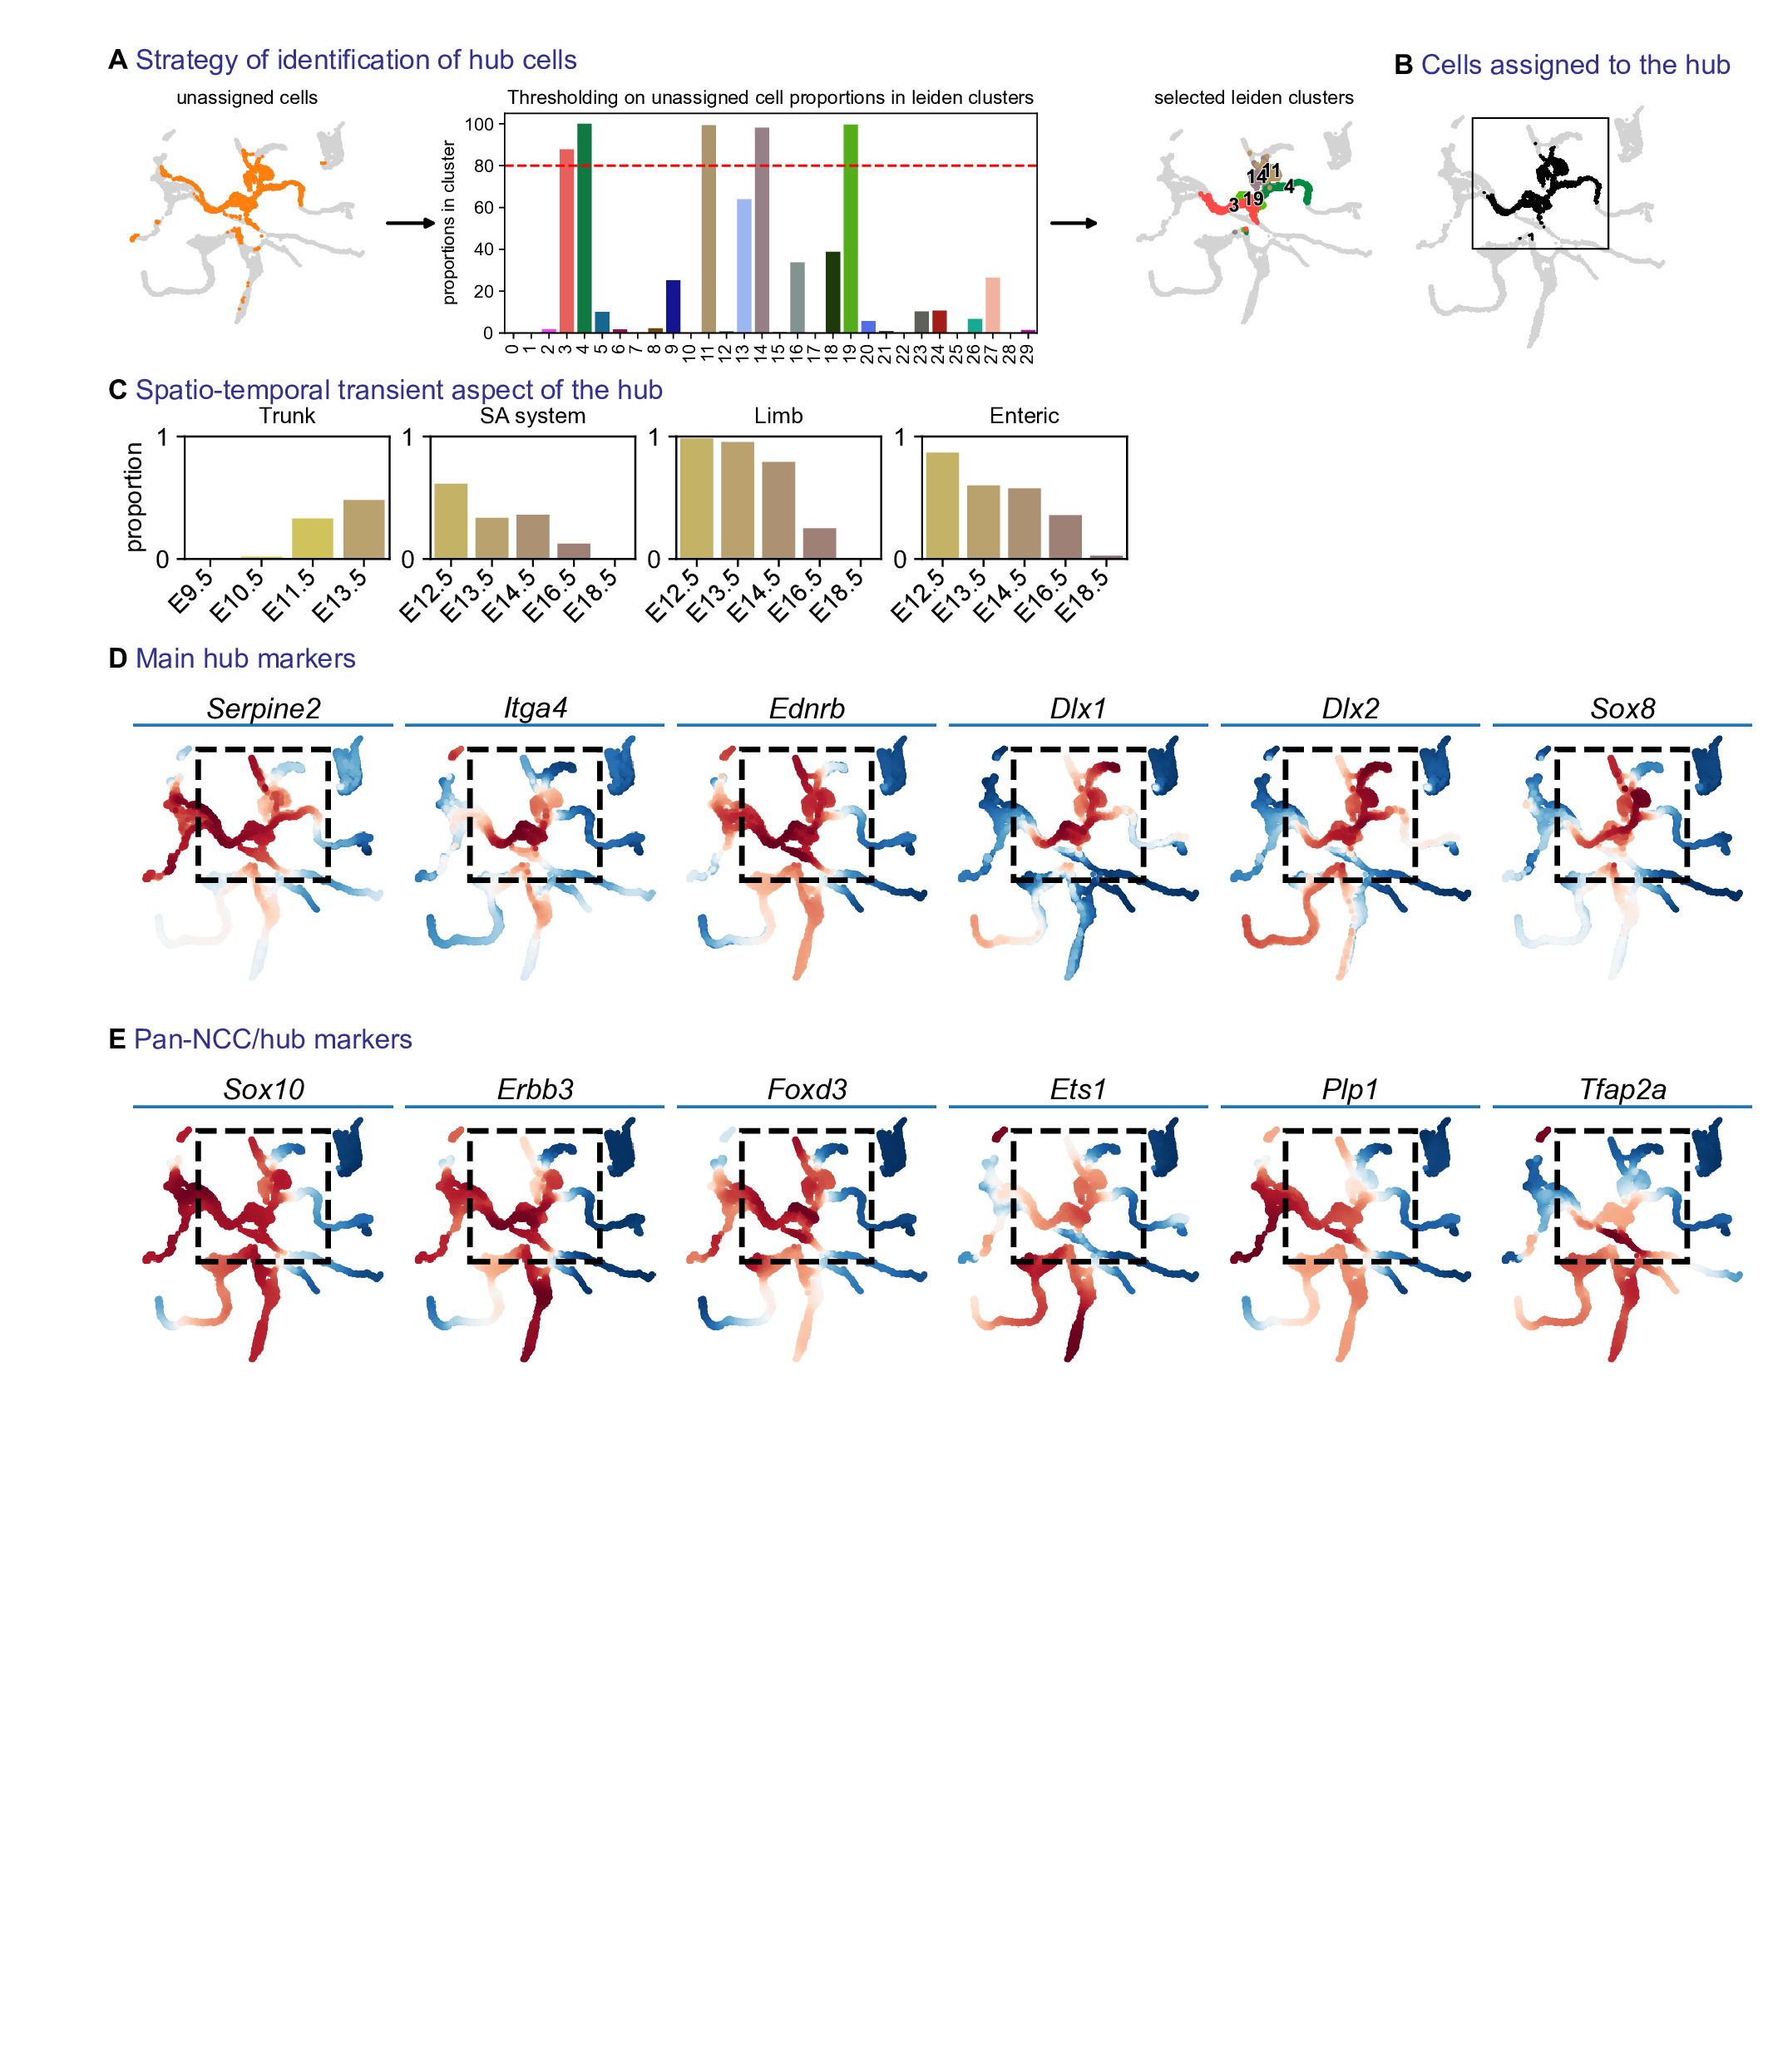

In [97]:
from IPython.display import Image
Image(filename='fig2.jpg') 

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


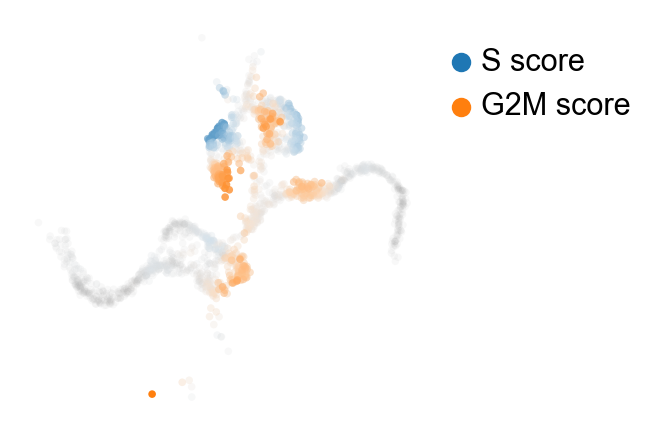

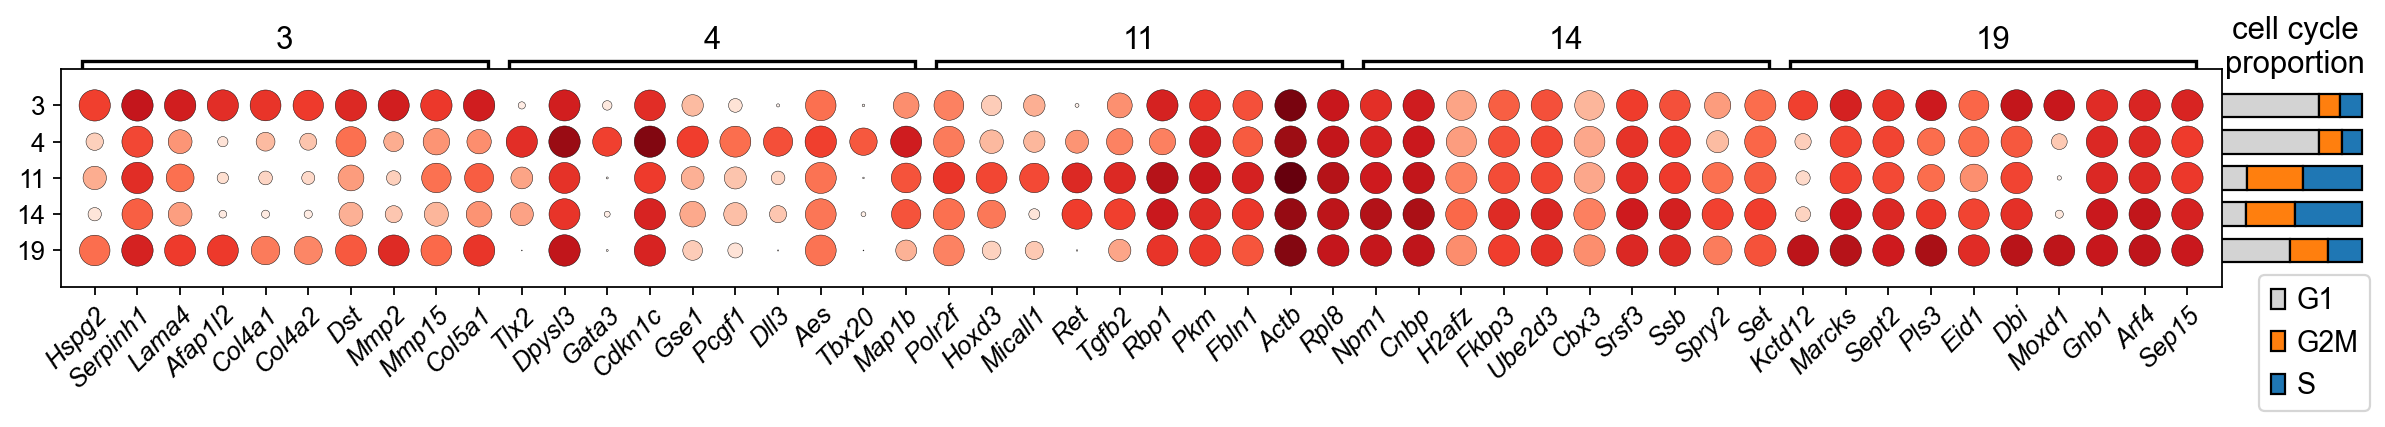

In [81]:
X_temp=adata_Hub.X.copy()
adata_Hub.X=adata_Hub.layers["scaled"].copy()
scv.tl.score_genes_cell_cycle(adata_Hub)
#scv.pp.neighbors(adata_Hub,use_rep="X_diff")
scv.pl.scatter(adata_Hub, color_gradients=['S_score', 'G2M_score'],size=30,
                  smooth=True, perc=[5, 95],show=False)

sc.tl.rank_genes_groups(adata_Hub,"leiden",method="wilcoxon")
sc.tl.dendrogram(adata_Hub,"leiden")

adata_Hub.X=X_temp

def remove_legend_dotplot(ax,swapped=False):
    main = ax["mainplot_ax"].get_position().bounds
    groups=ax["gene_group_ax"].get_position().bounds
    leg=ax["size_legend_ax"].get_position().bounds
    tot_width=leg[0]+leg[2]
    
    toadd=tot_width-groups[0] if swapped else leg[2]

    ax["size_legend_ax"].remove()
    ax["color_legend_ax"].remove()
    if swapped:
        ax["gene_group_ax"].set_position([groups[0]+toadd,groups[1],groups[2],groups[3]])
    else:
        ax["gene_group_ax"].set_position([groups[0],groups[1],groups[2]+toadd,groups[3]])
    ax["mainplot_ax"].set_position([main[0],main[1],main[2]+toadd,main[3]])
    ax["mainplot_ax"].figure.set_figwidth(ax["mainplot_ax"].figure.get_figwidth()-1.5)

props=adata_Hub.obs.groupby(["leiden","phase"]).size().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

props=props.unstack()

sc.set_figure_params()
import numpy as np
fig, ax= plt.subplots(1,2,figsize=(20,1.7),gridspec_kw=dict(width_ratios=[20,1],wspace=.0))
axs=sc.pl.rank_genes_groups_dotplot(adata_Hub,groupby="leiden",show=False,dendrogram=False,ax=ax[0])
remove_legend_dotplot(axs)
main=axs["mainplot_ax"].get_position().bounds
axs["mainplot_ax"].set_position([main[0],main[1],main[2],0.8])
groups=axs["gene_group_ax"].get_position().bounds
axs["gene_group_ax"].set_position([groups[0],0.8+main[1],groups[2],groups[3]])
#axs["mainplot_ax"].set_position([main[0],main[1],main[2]+toadd,main[3]])
plt.setp(axs['mainplot_ax'].get_xticklabels(), rotation=45, ha="right", 
         rotation_mode="anchor",style="italic");

data_lst = [props[p] for p in props.columns]
color_lst = ["lightgrey", "tab:orange","tab:blue"]
left = 0
for data, color in zip(data_lst, color_lst):
    ind = np.arange(data.shape[0])   
    ax[1].barh(ind, data, color=color,height=.65, left=left,edgecolor="black",label=data.name)
    left += data
ax[1].axis("off")
ax[1].set_position([0.91,.21,.05,0.68])
ax[1].set_title("cell cycle\nproportion")
ax[1].legend(bbox_to_anchor=(1.1, 0.05))
ax[1].invert_yaxis()
plt.savefig("figures/fig3-C.pdf",bbox_inches="tight")

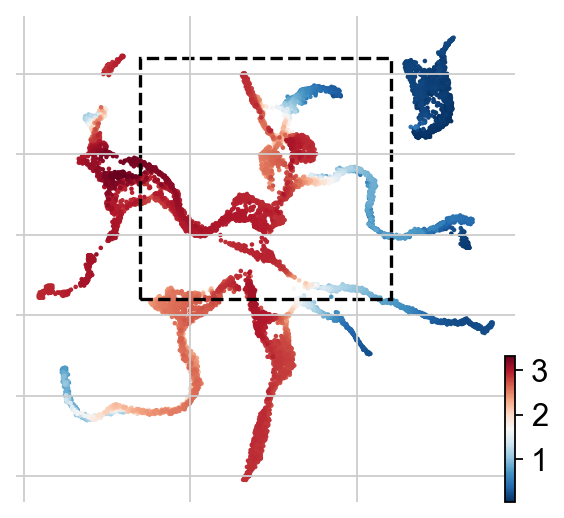

In [ ]:
import matplotlib.patches as patches
ax=scv.pl.umap(adata,color="Sox10",cmap="RdBu_r",show=False,layer="palantir_imp",title="")
rect = patches.Rectangle((-3,1),15,15,linewidth=1.5,edgecolor='k',facecolor='none',linestyle="--")
ax.add_patch(rect)

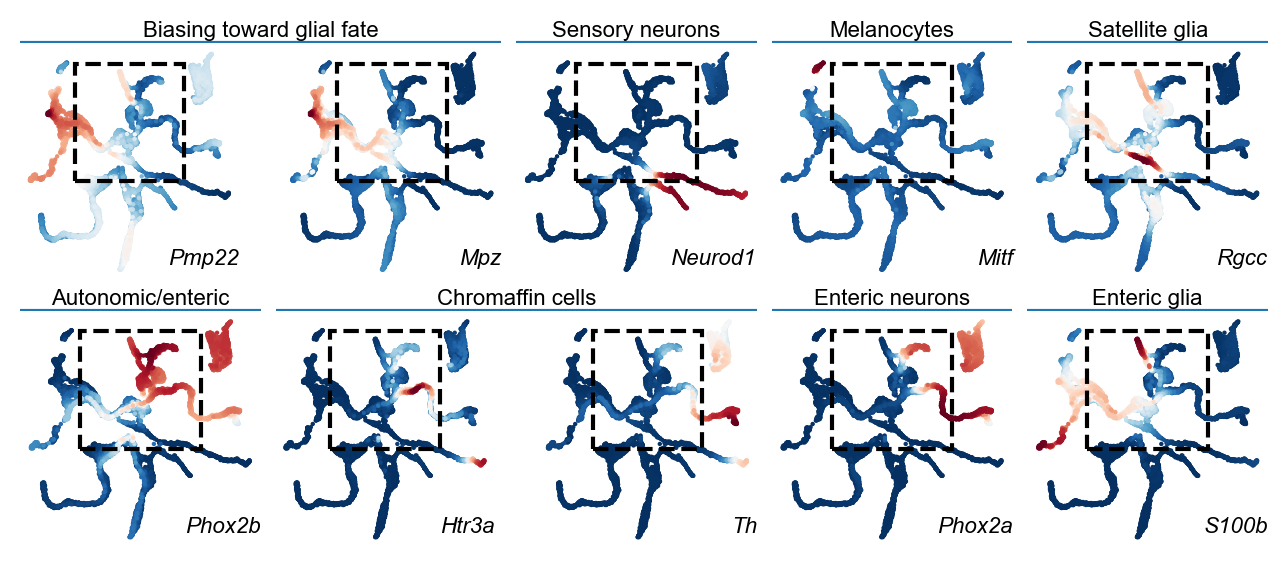

In [101]:
markers={"Biasing toward glial fate":["Pmp22","Mpz"],
         "Sensory neurons":"Neurod1",
         "Melanocytes":"Mitf",
         "Satellite glia":"Rgcc",
         "Autonomic/enteric":"Phox2b",
         "Chromaffin cells":["Htr3a","Th"],
         "Enteric neurons":"Phox2a",
         "Enteric glia":"S100b"}
celltypes=list(markers.keys())

scv.set_figure_params(figsize=(2.6,2.6),dpi_save=300)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8,7))
def set_title(ax,title):
    ax.text(0.5, 0.1, title, va="bottom", ha="center",fontsize=8)
    ax.axis("off")
    ax.axhline(0)
    
def plot_marker(ax,g):
    scv.pl.umap(adata,color=g,colorbar=False,s=10,layer="palantir_imp",title="",show=False,ax=ax)
    rect = patches.Rectangle((-3,1),15,15,linewidth=1.5,edgecolor='k',facecolor='none',linestyle="--")
    ax.add_patch(rect)
    ax.text(1, 0.05,g,fontsize= 8,
                va="bottom", ha="right", transform=ax.transAxes,
                fontdict={"fontstyle":"italic"})
    
def plot_multi(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)
    ncol=len(markers[celltype])
    gs0000 = gridspec.GridSpecFromSubplotSpec(1, ncol,subplot_spec=gs000[1])
    axt=[]
    for c in range(gs0000.ncols):
        axt.append(fig.add_subplot(gs0000[c]))
        plot_marker(axt[c],markers[celltype][c])
        
def plot_single(celltype,gs):
    gs000 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs,height_ratios=[1,10],hspace=0)    
    axt= fig.add_subplot(gs000[0])   
    set_title(axt,celltype)    
    axt = fig.add_subplot(gs000[1])
    plot_marker(axt,markers[celltype])
        
gs0 = gridspec.GridSpec(4, 1, figure=fig,hspace=0.025)
ix=0
## first row

lens=[[2,1,1,1],[1,2,1,1]]

for i,rlen in enumerate(lens):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, len(rlen), width_ratios=rlen,subplot_spec=gs0[i],wspace=0.05)
    for j,l in enumerate(rlen):
        if l >1:
            plot_multi(celltypes[ix],gs00[j])
            ix=ix+1
        else:
            plot_single(celltypes[ix],gs00[j])
            ix=ix+1



plt.savefig("figures/fig3-A.pdf",bbox_inches="tight")

In [102]:
fname="fig3"

In [103]:
%%bash -s $fname
cat<<EOF >$1.tex
\documentclass[11pt]{article}
\usepackage[paperheight=211mm,paperwidth=180mm]{geometry}
 \geometry{
 left=5mm,
 right=5mm,
 top=5mm,
 bottom=5mm,
 }

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx} 
\begin{document}
\setmainfont{Arial}

\definecolor{Blue}{RGB}{50, 49, 145}

\noindent
\scriptsize



\raggedright \textbf{A} \textcolor{Blue}{Fate biasing from hub}
\includegraphics[width=1\textwidth]{figures/fig3-A.pdf}

\raggedright \textbf{C} \textcolor{Blue}{Intra-hub heterogeneity}
\includegraphics[width=1\textwidth]{figures/fig3-C.pdf}


\hfill
\clearpage


EOF

echo "\end{document}" >> $1.tex

xelatex --shell-escape $1.tex
rm $1.tex
convert -flatten -density 300 $1.pdf $1.jpg
identify $1.pdf

This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)
 \write18 enabled.
entering extended mode
(./fig3.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption.sty
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption3.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/xetex.def))
(/usr/share/texlive/texmf-dist

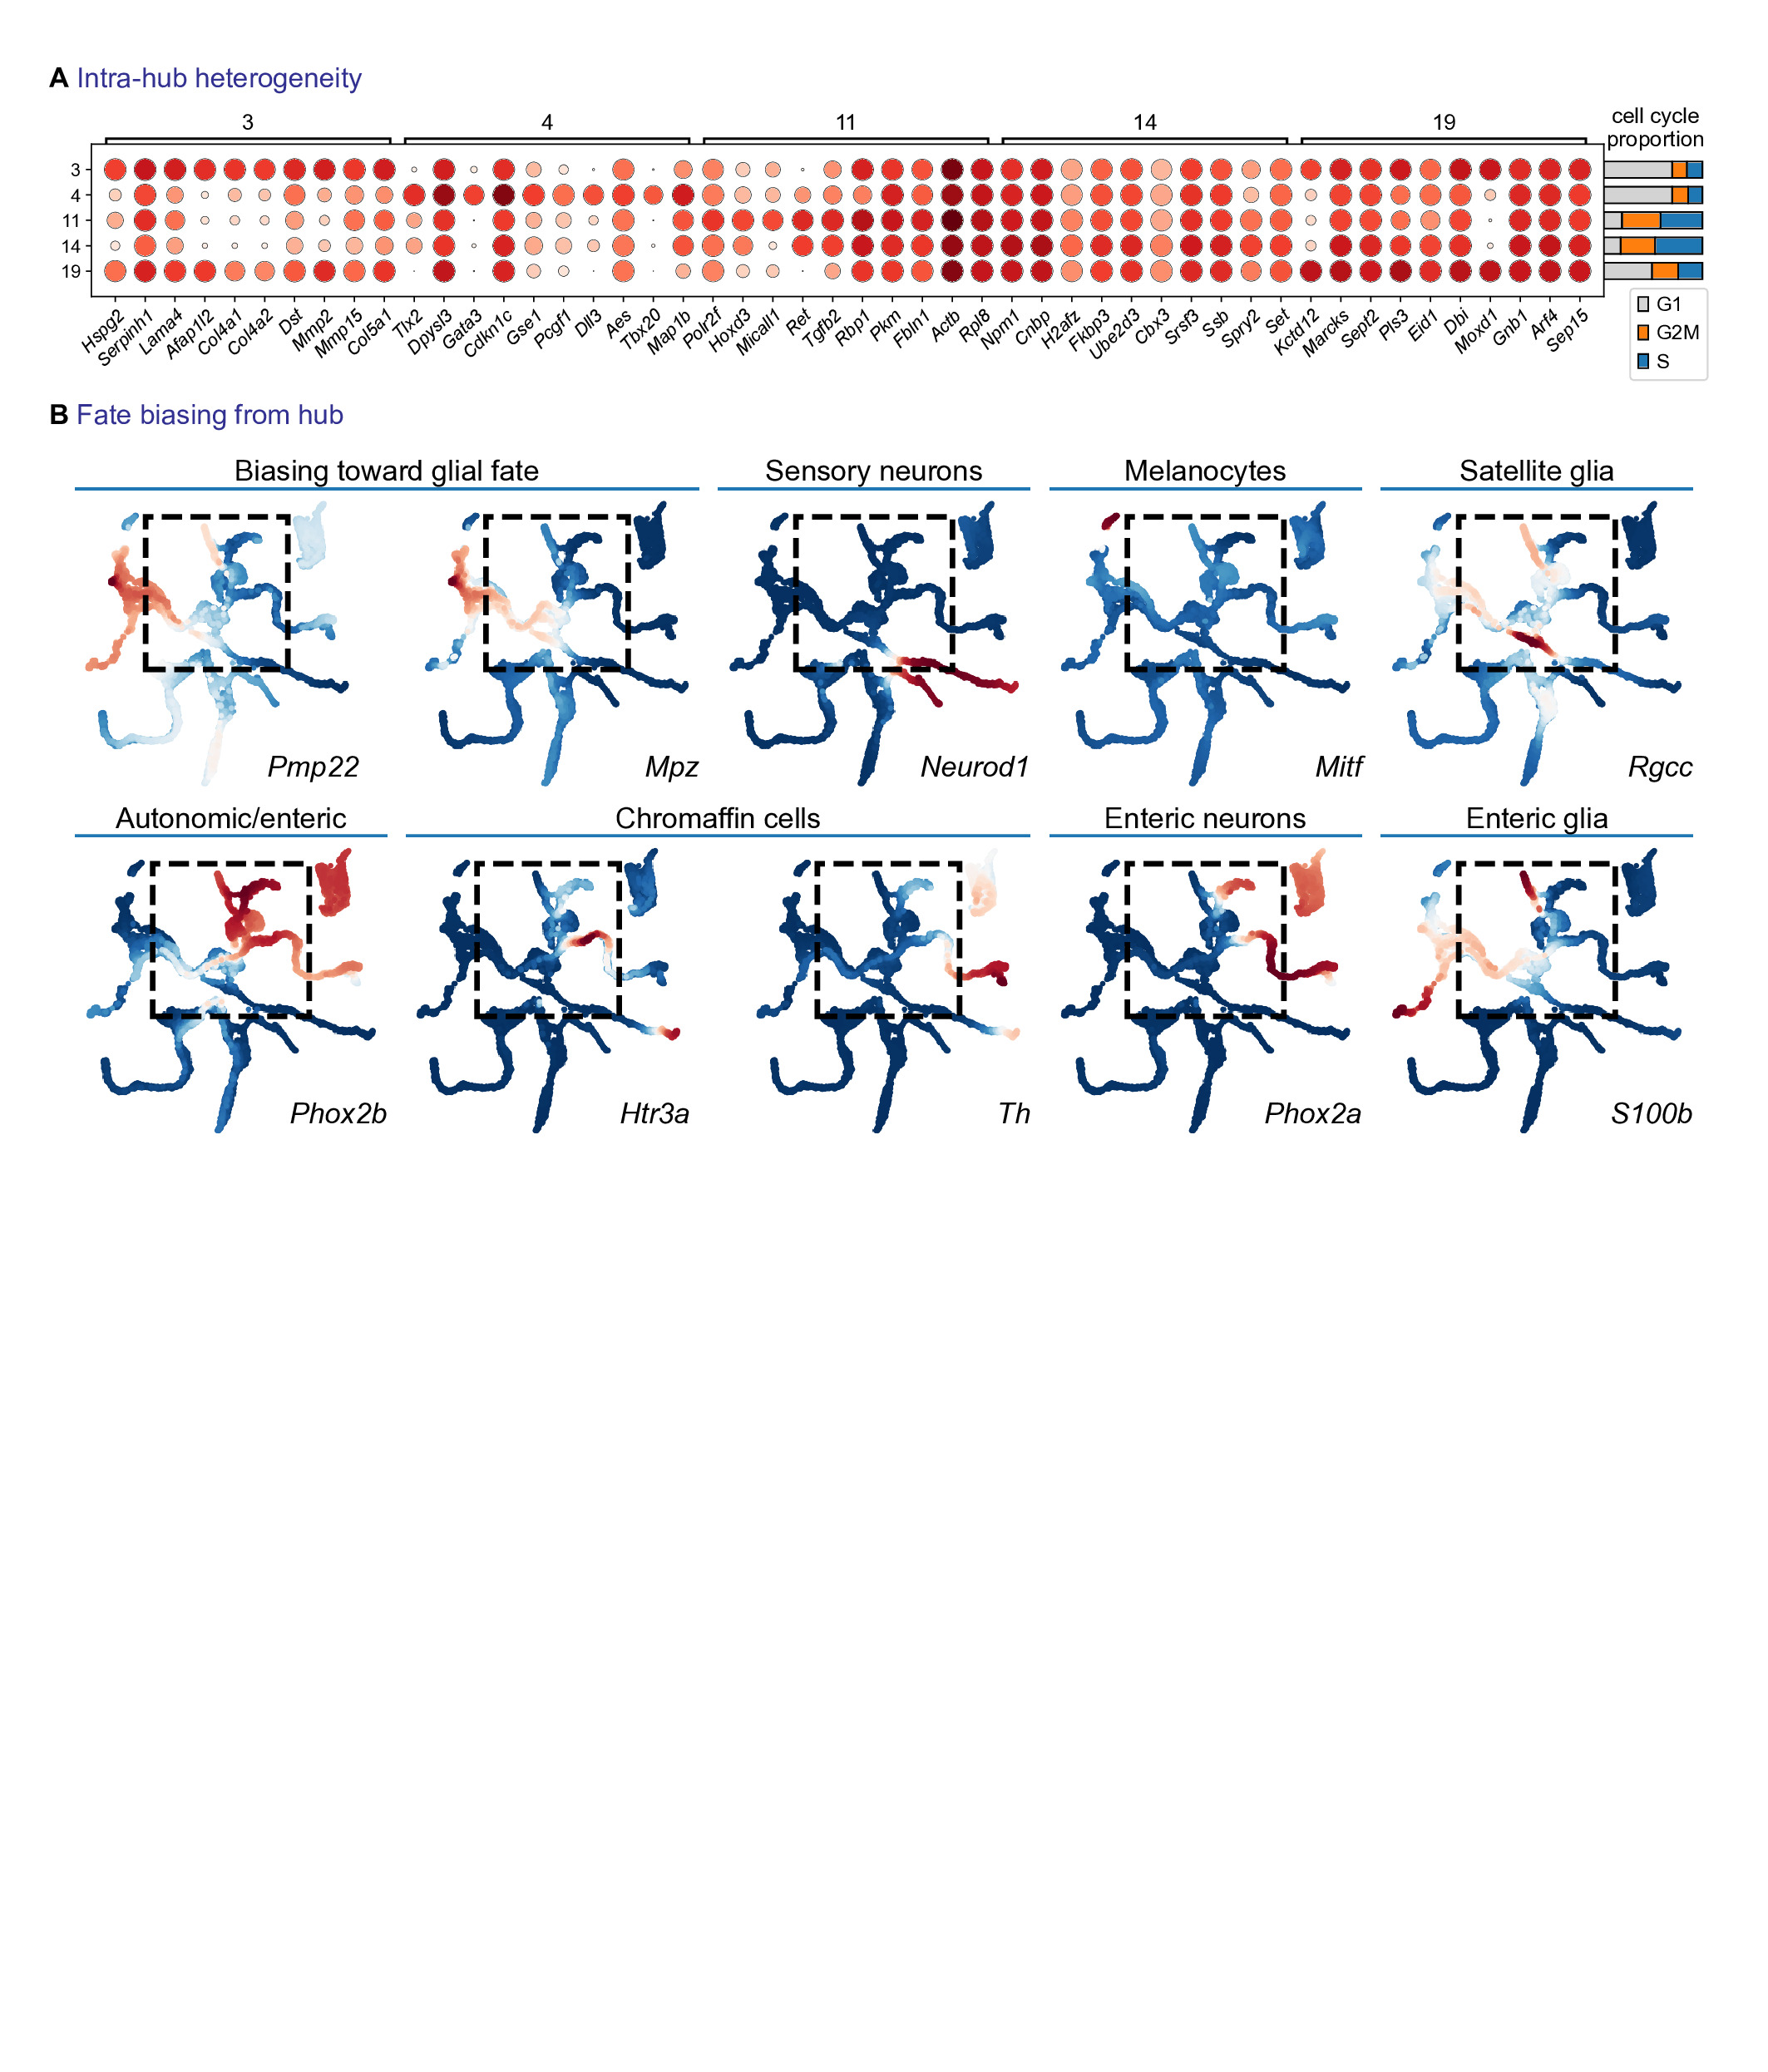

In [104]:
from IPython.display import Image
Image(filename=fname+'.jpg') 